# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/gaia/
!ls

# Download data

In [ ]:
if False:
  !wget -O galah_dr4_allstar_240705.fits https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_allstar_240705.fits

In [ ]:
if False:
  !wget -O galah_dr4_vac_dynamics_240705.fits https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_vac_dynamics_240705.fits

In [ ]:
if False:
    !wget -O ONeill2024_LocalBubble_ShellProperties_A0.5.fits https://dataverse.harvard.edu/api/access/datafile/8943783
    !wget -O ONeill2024_LocalBubble_Shell_xyz.fits https://dataverse.harvard.edu/api/access/datafile/8955365

# Install

In [ ]:
! pip install wget --quiet

# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cpu
device_count:  0
Torch version:  2.6.0+cu124
torch.version.cuda:  12.4
Is CUDA enabled? False


# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

# Fcn

In [ ]:
# see Sven's paper GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2
vlsr_sun = 15.17 # km/s,


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 500)

# Define the Gaussian function
def gaussian(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

In [ ]:
def plot_star_hi_abs(GASS_nhi_thin_map, glon_cnm, glat_cnm, glon_det, glat_det, hi_det_src_id, closest_coords_glon, closest_coords_glat):
    xlbs = 18
    tlbs = 16
    cmap = 'viridis'
    cmap = 'bwr'

    cm = mpl.colormaps['cool'] # winter, cool, hsv, jet


    # Plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection=w)

    # Display the moment map image
    im = ax.imshow(GASS_nhi_thin_map, cmap='gray')
    # ax.invert_yaxis()  # Flips the Y axis
    # ax.invert_xaxis()  # Flips the X axis

    sct = ax.scatter(glon_cnm, glat_cnm, s=40, c=vcencnm, transform=ax.get_transform('galactic'),
              marker='o', cmap=cmap,
              label='HI absorption detections')
    ax.scatter(glon_det[hi_det_src_id], glat_det[hi_det_src_id], s=150, transform=ax.get_transform('galactic'), marker='x', c='c', alpha=0.8, label='Absorption L.O.S')
    ax.scatter(closest_coords_glon, closest_coords_glat, s=110, transform=ax.get_transform('galactic'), marker='*', c='magenta', alpha=0.8, label='Star')

    ax.plot(ch_xcirc, ch_ycirc,
            transform=ax.get_transform('galactic'),
            lw=3.5,
            c='lightcyan',
            ls='--',
            zorder=0,
            alpha=0.5,
            label='Horizontal filament'
          )

    ax.plot(cv_xcirc, cv_ycirc,
            transform=ax.get_transform('galactic'),
            lw=3.5,
            c='gray',
            ls='--',
            alpha=0.5,
            zorder=0,
            label='Vertical filament'
          )


    # Approximate locations of LMC, SMC
    ax.plot(SMC_xcirc,
            SMC_ycirc,
            transform=ax.get_transform('galactic'),
            lw=2.,
            color='r',
            ls='--',
            label='Toward SMC'
          )
    ax.plot(LMC_xcirc,
            LMC_ycirc,
            transform=ax.get_transform('galactic'),
            lw=2.,
            color='y',
            ls='--',
            label='Toward LMC'
          )

    # Add axes labels
    ax.set_xlabel('Galactic Longitude [degrees]', fontsize=xlbs)
    ax.set_ylabel('Galactic Latitude [degrees]', fontsize=xlbs)

    # Color bar
    cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=0.01, pad=0.006, aspect=55)
    cbar.ax.set_ylabel('CNM Velocity [km/s]', rotation=90, labelpad=5., fontsize=15)
    cbar.ax.tick_params(labelsize=16)

    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=tlbs, pad=4)
    ax.tick_params(axis='y', labelsize=tlbs)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=4)


    ax.legend(loc='upper left', fontsize=16)

    plt.grid(color='gray', lw=0.5)
    plt.show()

In [ ]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def download_galah_data(save_path, sobject_id):
    sobject_id = str(sobject_id)
    output_star_id_file = save_path / f'{sobject_id}_allstar_fit_spectrum.fits'
    # print(output_star_id_file)
    save_path = str(save_path)

    if not os.path.exists(output_star_id_file):
        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_spectrum.fits'
        wget.download(url, out=save_path)

        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_comparison.pdf'
        wget.download(url, out=save_path)

In [ ]:
def rv_to_lsr(ra, dec, rv, u_sun=11.10, v_sun=12.24, w_sun=7.25):
    """
    Convert heliocentric radial velocities to the Local Standard of Rest (LSR).

    Parameters:
    -----------
    ra : float or array-like
        Right Ascension in degrees
    dec : float or array-like
        Declination in degrees
    rv : float or array-like
        Heliocentric radial velocity in km/s
    u_sun : float, optional
        Solar motion in km/s toward the Galactic center
    v_sun : float, optional
        Solar motion in km/s in direction of Galactic rotation
    w_sun : float, optional
        Solar motion in km/s toward the North Galactic Pole

    Returns:
    --------
    float or array-like
        Radial velocity in the LSR frame in km/s
    """
    # Create SkyCoord object
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

    # Convert to Galactic coordinates
    l = coords.galactic.l.radian
    b = coords.galactic.b.radian

    # Calculate projection of solar motion
    proj_sun_vel = (
        u_sun * np.cos(b) * np.cos(l) +
        v_sun * np.cos(b) * np.sin(l) +
        w_sun * np.sin(b)
    )

    # Convert to LSR
    rv_lsr = rv + proj_sun_vel

    return rv_lsr







def rv_to_lsr_lb(glon, glat, rv, u_sun=11.10, v_sun=12.24, w_sun=7.25):
    """
    Convert heliocentric radial velocities to the Local Standard of Rest (LSR).

    Schönrich et al. (2010): https://academic.oup.com/mnras/article/403/4/1829/1054839
    and https://www.aanda.org/articles/aa/pdf/2024/09/aa50936-24.pdf

    Parameters:
    -----------
    glon : float or array-like
        Galactic longitude in degrees
    glat : float or array-like
        Galactic latitude in degrees
    rv : float or array-like
        Heliocentric radial velocity in km/s
    u_sun : float, optional
        Solar motion in km/s toward the Galactic center
    v_sun : float, optional
        Solar motion in km/s in direction of Galactic rotation
    w_sun : float, optional
        Solar motion in km/s toward the North Galactic Pole

    Returns:
    --------
    float or array-like
        Radial velocity in the LSR frame in km/s
    """
    # Convert to Galactic coordinates
    l = np.radians(glon)
    b = np.radians(glat)

    # Calculate projection of solar motion
    proj_sun_vel = (
        u_sun * np.cos(b) * np.cos(l) +
        v_sun * np.cos(b) * np.sin(l) +
        w_sun * np.sin(b)
    )

    # Convert to LSR
    rv_lsr = rv + proj_sun_vel

    return rv_lsr

In [ ]:
def wavelength_to_rv(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity from observed and rest wavelengths using the
    relativistic Doppler formula.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    # Convert wavelengths to float if they're strings
    wavelength_obs = np.float64(wavelength_obs)
    wavelength_rest = np.float64(wavelength_rest)

    # Calculate velocity using relativistic formula
    c = const.c.to('km/s').value  # speed of light in km/s

    # (λ_obs / λ_rest)^2 = (1 + v/c)/(1 - v/c)
    # Solving for v:
    z = wavelength_obs / wavelength_rest
    rv = c * (z**2 - 1) / (z**2 + 1)

    return rv

def wavelength_to_rv_simple(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity using the simple (non-relativistic) Doppler formula.
    Use this only for v << c.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    c = const.c.to('km/s').value  # speed of light in km/s

    # Simple Doppler formula: v/c = Δλ/λ
    # rv = c * (wavelength_obs - wavelength_rest) / wavelength_rest
    rv = c * (wavelength_obs - wavelength_rest) / wavelength_obs

    return rv

In [ ]:
def wavelength_to_vlsrk(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
def wavelength_to_vlsrk_with_galah_correction(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        galah_allstar['rv_comp_1']: See GALAH
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths) + rv_comp_1
    # vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk

In [ ]:
def binned_avg(x: np.ndarray, y: np.ndarray, bin_edges: np.ndarray, n_resamples = 1000):
    from scipy import stats

    # Calculate the bin average using scipy
    bin_avg, _, _ = stats.binned_statistic(x, y, statistic='mean', bins=bin_edges)

    # Container for bin averages
    bin_avg_arr = []

    # Perform bootstrap resampling and calculate bin averages
    for _ in range(n_resamples):
        resample_indices = np.random.choice(len(y), size=len(y), replace=True)
        resample_y= y[resample_indices]
        bin_avg_resample, _, _ = stats.binned_statistic(x, resample_y, statistic='mean', bins=bin_edges)
        bin_avg_arr.append(bin_avg_resample)

    # Compute the upper and lower percentiles of the bin averages
    bin_avg_arr = np.array(bin_avg_arr)
    bin_mean_arr = np.mean(bin_avg_arr, axis=0)
    bin_avg_upper = np.percentile(bin_avg_arr, 97.5, axis=0) - bin_mean_arr + bin_avg
    bin_avg_lower = np.percentile(bin_avg_arr, 2.5, axis=0) - bin_mean_arr + bin_avg

    return bin_avg, bin_avg_upper, bin_avg_lower

In [ ]:
# Define the Gaussian function with FWHM
def gaussian(x, A, x0, FWHM):
    sigma = FWHM / 2.3548
    return A * np.exp(-(x-x0)**2 / (2*sigma**2))

In [ ]:
def normalize_spectrum(spectrum):
    min_val = np.min(spectrum)
    max_val = np.max(spectrum)

    # Handle the case where all values are the same
    if max_val == min_val:
        return np.zeros_like(spectrum)  # Return a spectrum of zeros or any consistent value

    # Apply min-max normalization
    normalized_spectrum = (spectrum - min_val) / (max_val - min_val)
    return normalized_spectrum

In [ ]:
def compute_column_density_KI(W_lambda_angstrom):
    """
    Compute the column density for weak lines:

    \[
    W_{\lambda} = \frac{\pi e^2}{m_e c^2} f \lambda^2 N
    \]

    Where:

    - \( e \) is the electron charge
    - \( m_e \) is the electron mass
    - \( c \) is the speed of light
    - \( f \) is the oscillator strength of the transition
    - \( \lambda \) is the wavelength of the line

    """
    # f = 0.3393  # Oscillator strength
    f = 0.332 # Oscillator strength
    lambda_ = 7698.9643 * u.Angstrom  # Wavelength in Angstrom lambda_rest = 7698.9643 # Angstroms

    # Convert equivalent width from Angstrom to meters
    W_lambda_m = (W_lambda_angstrom * u.Angstrom).to(u.m)

    # Compute column density using the formula
    N = (W_lambda_m * const.m_e * const.c**2) / (np.pi * const.e.gauss**2 * f * lambda_.to(u.m)**2)

    return N.to(10**(10)/u.cm**2)  # This ensures the column density is returned in SI units (m^-2)

In [ ]:
def mollweide_histogram(ra, dec, distance, eq_width, bin_size=1000, nside=32):
    """
    Plots a histogram in Mollweide projection using HEALPix binning that shows the median
    equivalent width for bins of distances, in galactic coordinates.

    Parameters:
    - ra (array): Right ascension in degrees.
    - dec (array): Declination in degrees.
    - distance (array): Distance in parsec.
    - eq_width (array): Equivalent width in Å.
    - bin_size (int, optional): The size of the distance bins. Default is 200 parsecs.
    - nside (int, optional): The resolution of the HEALPix map. Default is 32.
    """
    # Convert equatorial coordinates (RA, Dec) to galactic coordinates (l, b)
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    l = c.galactic.l.degree
    b = c.galactic.b.degree

    # Convert (l, b) to HEALPix indices
    indices = hp.ang2pix(nside, l, b, lonlat=True)

    # Get maximum distance for binning
    max_dist = np.max(distance)

    # Create bins for distances
    bins = np.arange(0, max_dist + bin_size, bin_size)

    for i in range(len(bins) - 1)[:2]:
        mask = (distance >= 0) & (distance < bins[i+1])
        if np.any(mask):
            median_map = np.full(hp.nside2npix(nside), np.nan)
            for ind in np.unique(indices[mask]):
                median_map[ind] = np.median(eq_width[(indices == ind) & mask])

            hp.mollview(
                median_map,
                title=f'N(KI) 7699',
                cmap='plasma',
                min=7,max=21,
                badcolor='None',
                bgcolor='None',
                unit = r'N(KI) 7699 / $10^{10}\,\mathrm{cm^{-2}}$'
            )
            hp.graticule()

            plt.savefig('figures/n_k_'+str(i)+'.png',dpi=200,bbox_inches='tight', transparent=True)
            plt.show()
            plt.close()

In [ ]:
def create_parallel_uncertainty_lines(x, y, x_err, confidence=0.95):
    """
    Create uncertainty envelope by plotting the outermost lines on both sides of the 1:1 line.

    Parameters:
    -----------
    x : array-like
        X values of data points
    y : array-like
        Y values of data points
    x_err : array-like
        Error values for X data points
    confidence : float, default=0.95
        Confidence level for the envelope (0-1)
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, if None, a new figure is created

    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure containing the plot
    ax : matplotlib.axes.Axes
        Axes containing the plot
    """

    # Convert inputs to numpy arrays
    x = np.array(x)
    y = np.array(y)
    x_err = np.array(x_err)

    # Calculate z-score for the given confidence level
    z = stats.norm.ppf((1 + confidence) / 2)

    # Sort data by x values for proper line creation
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    x_err_sorted = x_err[sort_idx]

    # For visualizing the envelope boundaries, create extended x range
    x_min = min(x_sorted - x_err_sorted)
    x_max = max(x_sorted + x_err_sorted)
    extension = (x_max - x_min) * 0.1  # Extend by 10% on each side
    x_extended = np.array([x_min - extension, x_max + extension])

    # Calculate the maximum positive deviation from 1:1 line
    max_positive_dev = max(y_sorted - x_sorted + z * x_err_sorted)

    # Calculate the maximum negative deviation from 1:1 line
    max_negative_dev = min(y_sorted - x_sorted - z * x_err_sorted)

    # Create the upper and lower boundary lines that are parallel to the 1:1 line
    y_upper = x_extended + max_positive_dev
    y_lower = x_extended + max_negative_dev

    return x_extended, y_lower, y_upper

In [ ]:
def get_angular_distance(glon_src, glat_src, star_glon, star_glat):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    star_glon_rad = np.radians(star_glon)
    star_glat_rad = np.radians(star_glat)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distance_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(star_glat_rad) +
        np.cos(glat_src_rad) * np.cos(star_glat_rad) *
        np.cos(glon_src_rad - star_glon_rad)
    )

    # Convert distances back to degrees
    angular_distance = np.degrees(angular_distance_rad)

    return angular_distance

In [ ]:
def find_nearby_stars(glon_src, glat_src, stars_glon, stars_glat, star_ids, radius_deg):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star
    radius_deg : float
        Search radius in degrees

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    stars_glon_rad = np.radians(stars_glon)
    stars_glat_rad = np.radians(stars_glat)
    radius_rad = np.radians(radius_deg)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distances_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(stars_glat_rad) +
        np.cos(glat_src_rad) * np.cos(stars_glat_rad) *
        np.cos(glon_src_rad - stars_glon_rad)
    )

    # Convert distances back to degrees
    angular_distances = np.degrees(angular_distances_rad)

    # Create boolean mask for stars within radius
    mask = angular_distances < radius_deg

    # Collect results for nearby stars
    nearby_coords = {
        'glon': stars_glon[mask],
        'glat': stars_glat[mask],
        'distances': angular_distances[mask],
        'ki_ew_ism': galah['ew_k_is'][mask]
    }

    nearby_ids = star_ids[mask]

    return nearby_ids, nearby_coords

# For plotting

In [ ]:

# Circle
def _circle(x, y, r):
    theta = np.linspace(0, 2*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_LMC = 279.
gb_LMC = -33.5
R_LMC = 5.

gl_SMC = 302.
gb_SMC = -44.5
R_SMC = 3.

LMC = dict(
    gl = gl_LMC,
    gb = gb_LMC,
    center = [gl_LMC, gb_LMC],
    glon_range = [270., 307.],
    glat_range = [-48., -25.],
    circ = _circle(gl_LMC, gb_LMC, R_LMC),
    name = 'Large Magellanic Cloud'
)


SMC = dict(
    gl = gl_SMC,
    gb = gb_SMC,
    center = [gl_SMC, gb_SMC],
    glon_range = [295., 315.],
    glat_range = [-50., -40.],
    circ = _circle(gl_SMC, gb_SMC, R_SMC),
    name = 'Small Magellanic Cloud'
)




gl_beam = 310.
gb_beam = -46.5
R_beam = 0.25 # in degrees
GASKAP_beam = dict(
    gl = gl_beam,
    gb = gb_beam,
    center = [gl_beam, gb_beam],
    circ = _circle(gl_beam, gb_beam, R_beam),
    name = 'GASKAP beam'
)

# SMC_xcirc = _circle(305., -41, 3.),
# LMC_xcirc = _circle(277., -33.5, 6.)


# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = SMC['circ']
LMC_xcirc, LMC_ycirc = LMC['circ']
beam_xcirc, beam_ycirc = GASKAP_beam['circ']

# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of all sources 2714


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
8,24,J004327-704135,SB30665_component_11a,10.863942,-70.693260,303.888848,-46.420157,B,215.136993,332.138000,...,5.895,131.210007,2.227711e+20,False,0.000643,M344-11,30665,30665,False,False
10,26,J013229-723956,SB30665_component_12a,23.123198,-72.665757,298.690805,-44.122841,B,138.602005,138.981995,...,4.800,127.029999,1.083733e+21,False,0.002100,M344-06,30665,30665,False,False
11,28,J002919-754018,SB30665_component_13a,7.330447,-75.671738,304.752927,-41.378221,B,185.477005,206.205994,...,4.860,7.050000,1.705849e+20,False,0.002592,M344-11,30665,30665,False,False
12,29,J002920-754008,SB30665_component_13b,7.334793,-75.668999,304.751919,-41.381065,B,70.438004,70.567001,...,4.735,156.479996,1.705849e+20,False,0.000732,M344-11,30665,30665,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709,0,J045631-762533,SB38845_component_245a,74.132371,-76.425960,288.737278,-32.932020,C,18.582001,20.014000,...,4.195,40.980000,0.000000e+00,False,-0.001994,M000-02,"38509,38845",38845,False,False
2710,0,J045907-753153,SB38845_component_261a,74.779860,-75.531478,287.674258,-33.105855,C,17.294001,21.070000,...,4.570,51.529999,0.000000e+00,False,-0.000745,M000-02,"38758,38845",38845,False,False
2711,0,J045340-751015,SB38758_component_264a,73.419855,-75.170876,287.418567,-33.556039,C,15.995000,17.537001,...,4.195,57.150002,0.000000e+00,False,0.004325,M000-02,"38758,38845",38758,False,False
2712,0,J060302-715904,SB33047_component_273a,90.760142,-71.984682,282.615941,-29.427549,C,16.532000,17.809999,...,3.845,84.059998,0.000000e+00,False,-0.017450,M000-02,"33047,38845",33047,False,False


# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/result_table_dr3_integrated_properties.csv
Number of rows 462,
 Number of columns: 45


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,flux_int,ra_hr,tau_noise_per_channel
0,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,...,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342,179.488998,0.240077,0.014621
1,J002144-741500,30665,J002144-741500-30665,5.433208,-74.249829,305.669096,-42.720187,0,B,122.134003,...,0.139190,3.164146,0.399856,3.152547,0.179060,2,3.561425,132.397995,0.362214,0.028466
2,J002223-742825,30665,J002223-742825-30665,5.597676,-74.473760,305.562542,-42.505801,0,B,103.077003,...,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425,206.740997,0.373178,0.019057
3,J002248-734007,30665,J002248-734007-30665,5.700254,-73.668709,305.692177,-43.305728,0,B,49.626999,...,0.084394,3.155461,0.213848,2.971679,0.125477,1,3.564467,49.803001,0.380017,0.057622
4,J002335-735529,30665,J002335-735529-30665,5.895892,-73.924770,305.565463,-43.060758,0,B,62.061001,...,0.093914,2.635446,0.234640,2.824470,0.128897,1,3.567508,61.556000,0.393059,0.018767


In [ ]:
df_det.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'min_opacity',
       'vel_min_opacity', 'peak_tau', 'e_peak_tau', 'n_h', 'ew', 'sigew',
       'ewfit', 'sigewfit', 'nhicnm', 'signhicnm', 'nhiwnm', 'signhiwnm',
       'fcnm', 'sigfcnm', 'Rfactor', 'sigRfactor', 'nhi', 'signhi', 'nhi_thin',
       'signhi_thin', 'ncnm', 'tsky', 'flux_int', 'ra_hr',
       'tau_noise_per_channel'],
      dtype='object')

In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/hires_result_CNM_components_dr3.csv
Number of rows 691,
 Number of columns: 39


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
galah0 = Table.read(allstar_file)
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
med_dist_lim = 10_000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
galah_sm = galah0[
    (glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > lmc_glat[0]) & (glat < lmc_glat[1]) & (np.log10(galah0['ew_k_is']) > -1.3) &
    (med_dist > 250.) & (med_dist < 300.) &
    (galah0['rv_k_is'] > -100.) & (galah0['rv_k_is'] < 120.)
  ]
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -48.) & (glat < lmc_glat[1]) & (med_dist > 0.) & (galah0['ew_k_is'] > 0.001) & np.isfinite(galah0['age'])]

In [ ]:
galah_fg = galah[(galah['l'] > lmc_glon[0]) & (galah['l'] < 310.) & (galah['b'] > -47.) & (galah['b'] < -27.5) & (galah['r_med'] > 300.) ]
galah_fg

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,V_UVW,l,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,km / s,deg,deg,,,deg,,,
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float64,float64,float64,float64,float64,float64,float64,float64
140711003901371,00000344-8035334,4634293351884119040,galah_main,411,allstar,56849.777,0.014375000260770321,-80.59261322021484,0,0,2,0,41.11634,56.862797,74.508354,74.35529,0.75043243,94,6000_4.50_0.25,6000_4.50_0.25,217.76161,True,18.772858,0.22027303,--,--,17.28126,1.001133,0.7266045808792114,6040.206,68.973495,4.339705,0.112795636,0.2037482,0.058379777,0,1.0890785,0.28752026,9.826623,1.493961,1.479389,0.1548087,0,-0.079275414,0.075655945,32,0.6295695,0.24040926,33,0.018985732,0.05317279,0,-0.10724424,0.035538476,0,-0.1108114,0.031804346,0,-0.06573639,0.046015963,0,-0.043022584,0.021478074,0,0.264057

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

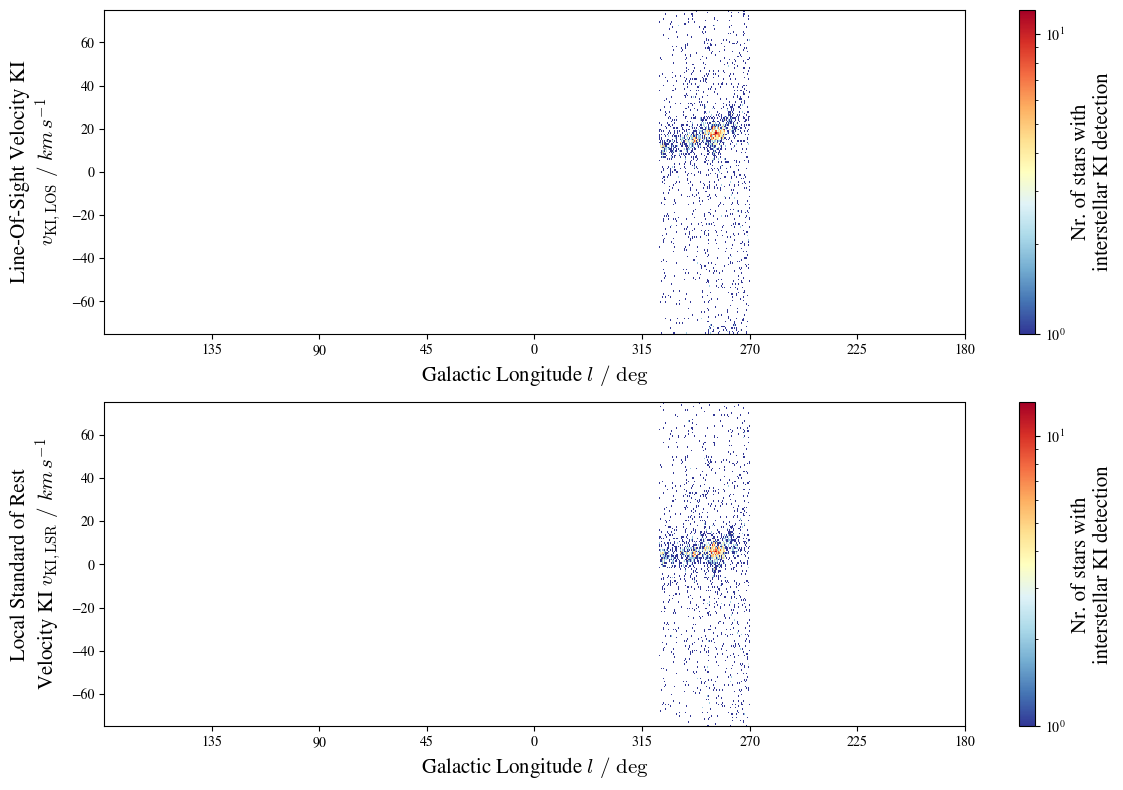

In [ ]:
# VLOS

has_k_is = np.isfinite(galah['rv_k_is_radio']) & np.isfinite(galah['l_flip'])

f, gs = plt.subplots(2,1,figsize=(12,8))

ax = gs[0]
h = ax.hist2d(
    galah['l_flip'][has_k_is],
    np.array(galah['rv_k_is_radio'][has_k_is]),
    bins = (300,np.linspace(-75,75,200)),
    cmin = 1,cmap = 'RdYlBu_r',
    norm = LogNorm()
);
cbar = plt.colorbar(h[-1],ax=ax)
cbar.set_label('Nr. of stars with\ninterstellar KI detection',fontsize=15)
ax.set_xlabel('Galactic Longitude $l~/~\mathrm{deg}$',fontsize=15)
ax.set_ylabel('Line-Of-Sight Velocity KI\n$v_\mathrm{KI,LOS}~/~{km\,s^{-1}}$',fontsize=15)
# ax.set_xlim(ax.get_xlim()[::-1])
xticks = np.arange(0, 360+180, 45)
xticks_name = xticks.copy()
xticks_name[xticks_name >= 360] -= 360
ax.set_xticks(xticks, xticks_name)
ax.set_xlim(360+180, 180)


#
ax = gs[1]

has_k_is = np.isfinite(galah['rv_k_is']) & np.isfinite(galah['l_flip'])

h = ax.hist2d(
    galah['l_flip'][has_k_is],
    np.array(galah['ki_v_lsr_radio'][has_k_is]),
    bins = (300,np.linspace(-75,75,200)),
    cmin = 1,cmap = 'RdYlBu_r',
    norm = LogNorm()
);
cbar = plt.colorbar(h[-1],ax=ax)
cbar.set_label('Nr. of stars with\ninterstellar KI detection',fontsize=15)
ax.set_xlabel('Galactic Longitude $l~/~\mathrm{deg}$',fontsize=15)
ax.set_ylabel('Local Standard of Rest\nVelocity KI $v_\mathrm{KI,LSR}~/~{km\,s^{-1}}$',fontsize=15)
# ax.set_xlim(ax.get_xlim()[::-1])
xticks = np.arange(0,360+180,45)
xticks_name = xticks.copy()
xticks_name[xticks_name >= 360] -= 360
ax.set_xticks(xticks, xticks_name)
ax.set_xlim(360+180,180)

plt.tight_layout()
# plt.savefig('figures/galah_dr4_ism_k_longitude_vs_velocity.pdf',bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection', 'ew_k_is', 'ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

,sobject_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,V_UVW,l,b,v_sun_projection,ew_k_is,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio
0,140713004601361,4685221429109310080,b'galah_main',182,b'allstar',56851.773438,0.001042,-75.687943,-37.697868,307.113381,-41.019988,-7.069331,0.019273,-104.650508,307.113381,7696.458320,-97.612949,-104.682280
1,140711003901371,4634293351884119040,b'galah_main',411,b'allstar',56849.777344,0.014375,-80.592613,-34.638008,305.515414,-36.276474,-7.123088,0.027323,2.011176,305.515414,7699.198877,9.133986,2.010898
2,140811005001160,4689447883087062784,b'galah_main',76,b'allstar',56880.710938,0.016250,-73.391861,-3.506775,307.934743,-43.233826,-7.027888,0.018979,-1.188739,307.934743,7699.114255,5.839036,-1.188853
3,140811005001171,4689462520335582592,b'galah_main',76,b'allstar',56880.710938,0.018292,-73.218887,-15.143014,307.998606,-43.400444,-7.024397,0.018959,-6.399740,307.998606,7698.980342,0.624655,-6.399742
4,140711003901061,4631183662419506048,b'galah_main',411,b'allstar',56849.777344,0.033167,-81.445580,-55.094646,305.255114,-35.449999,-7.127760,0.032334,3.817190,305.255114,7699.245377,10.944551,3.816791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17943,140711003901032,6352336620255046912,b'galah_main',411,b'allstar',56849.777344,359.947052,-80.983002,-7.744434,305.409765,-35.895384,-7.122000,0.029172,1.230774,305.409765,7699.178807,8.352541,1.230541
17944,150828004701380,6353031550259896064,b'galah_main',321,b'allstar',57262.667969,359.958282,-78.948608,25.830523,306.039658,-37.866417,-7.108079,0.021392,-186.897080,306.039658,7694.347142,-179.896888,-187.004966
17945,141104003301215,6379489613954820864,b'galah_main',133,b'allstar',56965.511719,359.960754,-74.590111,-30.124155,307.515543,-42.075811,-7.047230,0.054913,8.193784,307.515543,7699.355704,15.240239,8.193009
17946,140711003901037,6352328000257170048,b'galah_main',411,b'allstar',56849.777344,359.961639,-81.128830,-54.155178,305.362962,-35.754562,-7.123348,0.023378,5.670360,305.362962,7699.292855,12.793162,5.669814


In [ ]:
galah_df = galah_df[~galah_df['field_id'].isin([-1, 7048, 7046, 7045, 7044, 7043, 7042, 7041, 7040, 7039, 1145, 7149, 7148, 7201, 7171, 7131, 1242, 7130, 7128, 1056, 7120, 1092, 7182, 291, 129, 7211, 7210, 7212, 7213, 211, 7157,  7139, 7141, 7142, 1162, 7143, 7129, 7129, 7075, 251, 182, 7075, 7074, 70, 95, 141, 233, 7140, 7127, 7121, 7132])]

In [ ]:
fg_stars_glon = galah_df.l.values
fg_stars_glat = galah_df.b.values
fg_galah_field_ids = galah_df.field_id.values
fg_ew_k_is = galah_df.ew_k_is.values

In [ ]:
# Get unique field IDs
unique_field_ids = np.unique(fg_galah_field_ids)

# Compute means for each field_id
field_lb_means = []
for field_id in unique_field_ids:
    mask = (fg_galah_field_ids == field_id)  # Mask rows with the current field_id
    glon_mean = np.mean(fg_stars_glon[mask])
    glat_mean = np.mean(fg_stars_glat[mask])
    field_lb_means.append((field_id, glon_mean, glat_mean))

# Print results
for field_id, glon_mean, glat_mean in field_lb_means:
    print(f"Field ID: {field_id}, Mean Glon: {glon_mean:.2f}, Mean Glat: {glat_mean:.2f}")

# Plot: LOS/Sources on maps

In [ ]:
# NHI Map
gaskap_nhi_file = gaskap_data_path / 'nhi_thin_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
gaskap_nhi, gaskap_nhi_hdr = fits.getdata(gaskap_nhi_file, header=True)
print(gaskap_nhi.shape)

gaskap_nhi_w = WCS(gaskap_nhi_hdr)
print(gaskap_nhi_w)

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999962 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


In [ ]:
# Moment Maps
moment0_file = GASS_data_path / 'moment0_LMC_fg.fits'
tb_file = data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
m0, hdr = fits.getdata(tb_file, header=True)
print(m0.shape)

w = WCS(hdr)
print(w)

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999963 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


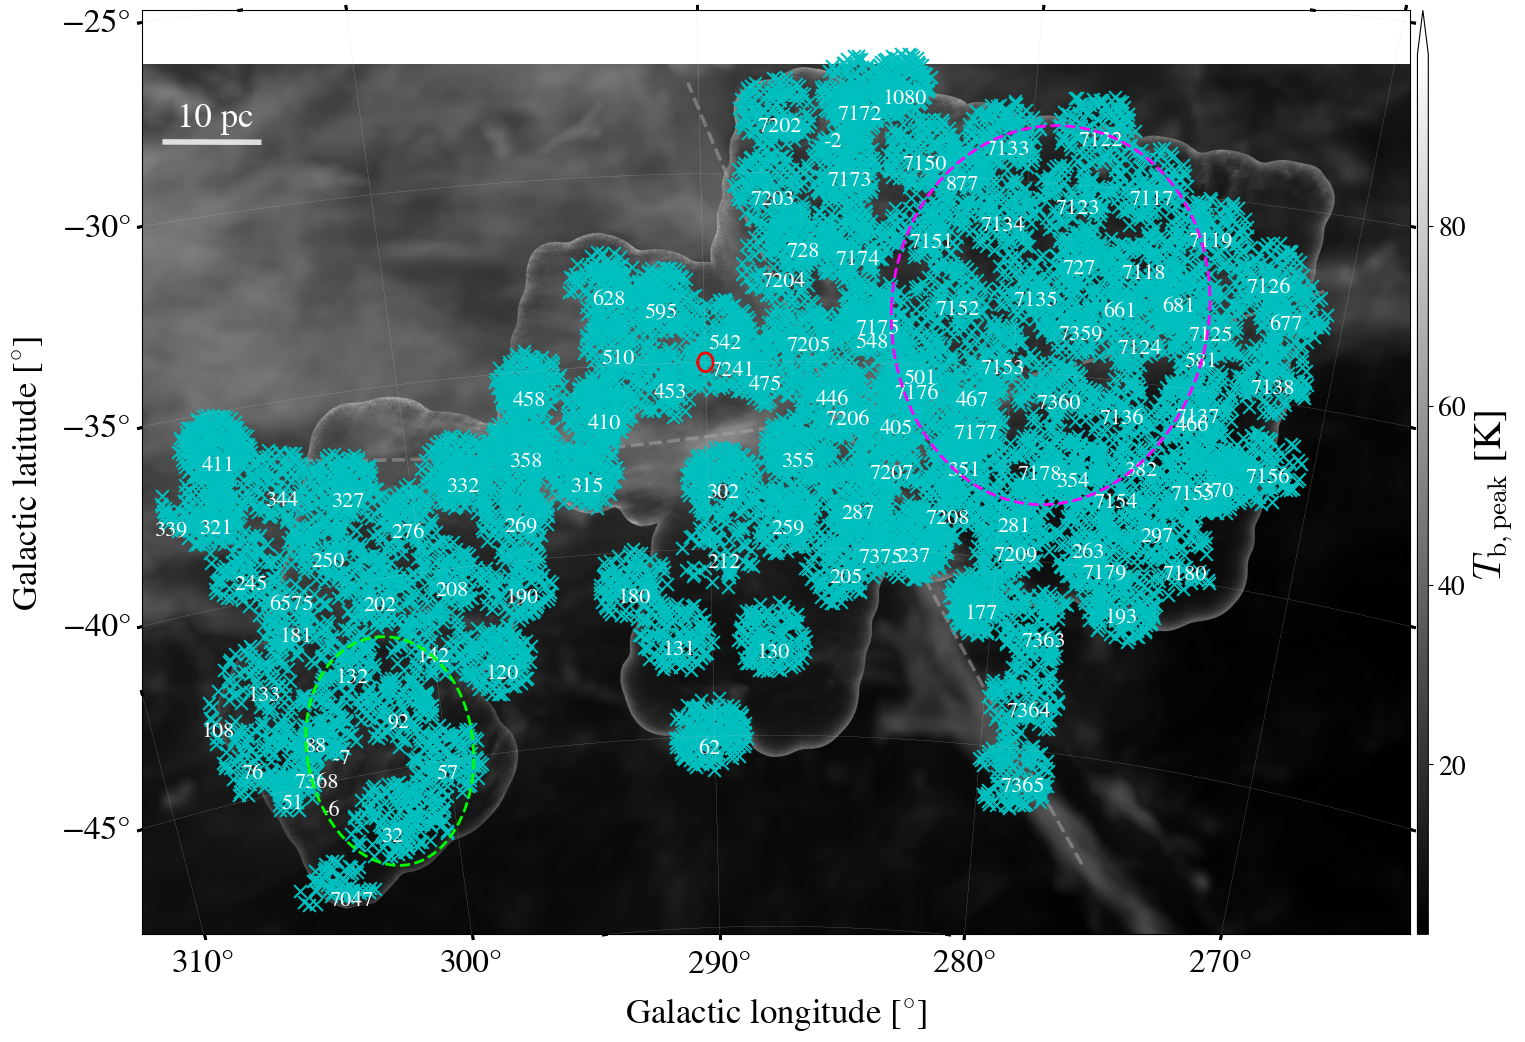

In [ ]:
# Plot
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection=w)

# Display the moment map image
im = ax.imshow(m0, cmap='gray')

ax.scatter(fg_stars_glon, fg_stars_glat,
           s=85,
           c='c',
           transform=ax.get_transform('galactic'),
           marker='x',
           label=f'Matching HI absorption ({000})')


# Print field_id
for field_id, glon_mean, glat_mean in field_lb_means:
    ax.text(glon_mean+0.5, glat_mean-0.5, str(field_id), transform=ax.get_transform('galactic'), fontsize=16, color='w')



ax.plot(ch_xcirc, ch_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label='Filamentary structures'
       )


ax.plot(cv_xcirc, cv_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label=''
       )


# # Approximate locations of LMC, SMC
ax.plot(SMC_xcirc,
        SMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=10,
        color='lime',
        ls='--',
        label='Towards SMC'
       )
ax.plot(LMC_xcirc,
        LMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=10,
        color='fuchsia',
        ls='--',
        label='Towards LMC'
       )

beam_xcirc, beam_ycirc = _circle(290., -35., 0.25)

# Beam
ax.plot(beam_xcirc,
        beam_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=10,
        color='r',
        ls='-',
        label='beam'
       )


ax.plot([303., 305.6], [-28.33, -28.], transform=ax.get_transform('galactic'), c='white', lw=4, alpha=0.8, label=f'')
ax.text(304.1, -27.6, '10 pc', dict(size=25, color='white'), horizontalalignment='center',  verticalalignment='center', transform=ax.get_transform('galactic'))

# Add axes labels
ax.set_xlabel("Galactic Longitude [degrees]", fontsize=16)
ax.set_ylabel("Galactic Latitude [degrees]", fontsize=16)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', extend='max', fraction=0.008, pad=0.005, aspect=85)
cbar.ax.set_ylabel('$T_\mathrm{b,peak}$ [K]', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=20)


# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=25)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=25)

ax.tick_params(axis='x', labelsize=24, pad=4)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)


ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

# For KI only: calc. sigma from KI spectra

In [ ]:
galah_tab_star_idx = galah_fg['sobject_id'].data.data
galah_tab_star_idx

array([140711003901371, 140811005001160, 140711003901061, ...,
       141104003301215, 140711003901037, 150828004701390], dtype='>i8')

# Read csv: GALAH stars with 3σ detections

In [ ]:
galah_fg_df_csv_file = data_path / 'galah_fg_df_3sigma_v2.csv'
galah_fg_df = pd.read_csv(galah_fg_df_csv_file)

galah_fg_df = galah_fg_df[ (galah_fg_df.ki_flux_std > 0.) & (galah_fg_df.ki_max_flux > 0.)]
galah_fg_df

,sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,...,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio,ki_flux_std,ki_max_flux,yn
0,140711003901371,b'00000344-8035334',4634293351884119040,b'galah_main',411,b'allstar',56849.777,0.014375,-80.592613,0,...,-36.276474,-7.123088,2.011176,305.515414,7699.198877,9.133986,2.010898,0.013848,0.098077,True
1,140811005001160,b'00000392-7323306',4689447883087062784,b'galah_main',76,b'allstar',56880.710,0.016250,-73.391861,0,...,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853,0.005235,0.061716,True
2,140711003901061,b'00000796-8126441',4631183662419506048,b'galah_main',411,b'allstar',56849.777,0.033167,-81.445580,0,...,-35.449999,-7.127760,3.817190,305.255114,7699.245377,10.944551,3.816791,0.013779,0.102848,True
3,140711003901030,b'00001085-8105228',4634208693785476224,b'galah_main',411,b'allstar',56849.777,0.045208,-81.089668,88,...,-35.795691,-7.126913,-39.625753,305.359306,7698.129698,-32.502364,-39.629277,0.011397,0.185799,True
4,140711003901040,b'00001107-8109523',4634205120372686848,b'galah_main',411,b'allstar',56849.777,0.046167,-81.164528,0,...,-35.723116,-7.127265,2.524415,305.336690,7699.212165,9.651369,2.524104,0.008755,0.062491,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14162,140713004601187,b'23465321-7603485',6377745234461961216,b'galah_main',182,b'allstar',56851.773,356.721741,-76.063499,40,...,-40.425995,-6.846530,7.740942,307.976944,7699.338921,14.586762,7.740232,0.008527,0.292616,True
14163,140711003901290,b'23465783-8024409',6352388026720180736,b'galah_main',411,b'allstar',56849.777,356.740967,-80.411362,0,...,-36.301464,-6.964172,2.765320,306.221478,7699.214163,9.729176,2.765004,0.013236,0.091930,True
14164,150829004901396,b'23470233-7718343',6377206821657536384,b'galah_main',251,b'allstar',57263.650,356.759705,-77.309525,0,...,-39.249065,-6.886457,12.924300,307.443934,7699.473060,19.809448,12.922991,0.013993,0.039822,False
14165,150828004701319,b'23470849-7904282',6352971901754303232,b'galah_main',321,b'allstar',57262.668,356.785492,-79.074501,0,...,-37.575466,-6.935098,4.019173,306.728448,7699.245616,10.953871,4.018773,0.008811,0.164115,True


In [ ]:
galah_star_idx = galah_fg_df['sobject_id'].values
print(galah_star_idx.shape)
galah_star_idx

In [ ]:
galah_df_star_idx = galah_star_idx.tolist()

In [ ]:
n_stars = len(galah_tab_star_idx)
n_stars

14393

In [ ]:
ki_flux_std = np.zeros(n_stars)
ki_max_res_flux = np.zeros(n_stars)
selec_yn = np.zeros(n_stars, dtype=bool)

for ik, star_id in enumerate(galah_tab_star_idx):

    # if ik > 1:
    #     break

    star_info = galah_fg[galah_fg['sobject_id'] == star_id]

    if (star_id in galah_df_star_idx):
        star_df_info = galah_fg_df[galah_fg_df['sobject_id'] == star_id]
        ki_flux_std[ik] = star_df_info['ki_flux_std'].values[0]
        ki_max_res_flux[ik] = star_df_info['ki_max_flux'].values[0]
        selec_yn[ik] = star_df_info['yn'].values[0]
        continue

    if (ik%100) == 0:
        print(ik, '/', n_stars)

    field_id = star_info['field_id'].data[0]
    path = data_path / 'galah' / f'field_{field_id}'
    make_dir(path)

    sobject_id_str = str(star_id)
    output_star_id_file = path / f'{sobject_id_str}_allstar_fit_spectrum.fits'

    download_galah_data(path, star_id)

    # stellar data: wavelength, flux, model
    tmp_spec_table = Table.read(output_star_id_file)

    wavelength = tmp_spec_table['wave']
    flux = tmp_spec_table['sob']
    flux_mod = tmp_spec_table['smod']

    # for KI
    waverange_idx = np.where((wavelength > 7695.5) & (wavelength < 7704.))[0] # 7720
    ki_wavelength = np.array(wavelength[waverange_idx])
    ki_flux = np.array(flux[waverange_idx])
    ki_flux_mod = np.array(flux_mod[waverange_idx])

    star_glon = star_info['l'].data[0]
    star_glat = star_info['b'].data[0]

    star_rv_comp_1 = star_info['rv_comp_1'].data[0] # km/s

    # Residuels, |model - data|
    res = np.abs(ki_flux_mod - ki_flux)
    max_res_id = np.argmax(res)
    ki_nu_max_res = ki_wavelength[max_res_id]


    # VSLRK of the max KI residual
    ki_ism_vlsr_obs = wavelength_to_vlsrk_with_galah_correction(ki_nu_max_res, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)

    # the width of Ki absorption feature (in Angstrom)
    sigma_k_ism_star_val = star_info['sigma_k_is'].data[0]

    # the Equivalent width of Ki absorption feature (in Angstrom)
    ki_ew_ism_star_val = star_info['ew_k_is'].data[0]

    # the Amplitude of Ki absorption feature (flux vs Angstrom)
    ki_amp = ki_ew_ism_star_val / sigma_k_ism_star_val / np.sqrt(2.*np.pi) # See Sven's email "KI line depth from EW and width"

    # To VLSRK
    ki_xvlsr = wavelength_to_vlsrk_with_galah_correction(ki_wavelength, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)


    ki_ew_ism_star = str(np.round(ki_ew_ism_star_val, 3))
    glon_star = np.round(star_info['l'].data[0], 3)
    glat_star = np.round(star_info['b'].data[0], 3)

    # distance to star
    star_med_dist = star_info['r_med'].data[0] # pc

    # Plot spectra
    res = np.abs(ki_flux_mod - ki_flux)
    res_std = np.std( np.concatenate((res[:5], res[-5:])) )
    max_res_id = np.argmax(res)
    max_res_val = res[max_res_id]
    xvlsr_max_res = star_info['ki_v_lsr_radio'].data[0]


    min_ki_mod_id = np.argmin(ki_flux_mod)
    ki_xvlsr_min_mod = ki_xvlsr[min_ki_mod_id]


    star_med_dist_cond = (star_med_dist > 230.)
    ki_ism_vlsr_obs_cond = (np.abs(ki_ism_vlsr_obs) < 30.)
    ki_max_res_cond = (max_res_val > 2.5*res_std)

    ki_flux_std[ik] = res_std
    ki_max_res_flux[ik] = max_res_val
    selec_yn[ik] = (max_res_val > 2.9*res_std)


    if False:
        # Plot
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)

        ax.plot(ki_xvlsr, ki_flux, 'k-', lw=3., label='data')
        ax.plot(ki_xvlsr, ki_flux_mod, 'r--', lw=2.5, label='Stellar model')
        ax.plot(ki_xvlsr, 1.1 + res, 'k--', lw=2.5, label='') # | model - data |


        # Calculate the Gaussian curve for the defined velocity range
        gaussian_curve = gaussian(velocity_range, 0.15, xvlsr_max_res, 4.)

        ax.axvline(x=xvlsr_max_res, color='m', ls='--', zorder=-2, label='ki_ism_vlsr (gauss)')

        ax.axhline(y = ki_amp, color = 'r', linestyle = '--')
        ax.axhline(y = ki_amp + 1.1, color = 'r', linestyle = '--')
        ax.axhline(y = 3.*res_std + 1.1, color = 'b', linestyle = ':', label='3sigma')

        ax.set_xlabel(r'Velocity [km/s]', fontsize=24)
        ax.set_ylabel(r'Flux / norm.', fontsize=24)


        ax.set_title(f'[KI] Star: {sobject_id_str}, KI EW = {ki_ew_ism_star}, ' + \
                      'l,b=(%5.2f, %5.2f), ' % (glon_star, glat_star) + \
                      'star rv=%5.2f, star dist=%5.2f}' % (star_rv_comp_1, star_med_dist),
                      fontsize=24)

        # Add axes labels
        ax.minorticks_on()
        ax.tick_params(axis='x', labelsize=20, pad=4)
        ax.tick_params(axis='y', labelsize=20)
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=8)
        ax.tick_params(which='minor', length=4)

        ax.set_xlim(-80, 80.)

        ymin_flux = np.min(np.min(flux_mod))
        ymax_flux = np.max(flux)


        ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
        leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=0.5) # handletextpad=-2.0

        # set the spacing between subplots
        plt.subplots_adjust(left=None,
                            bottom=None,
                            right=None,
                            top=None,
                            wspace=0.2,
                            hspace=0.3
                            )

        # plt.tight_layout()
        plt.show()
        plt.close()
    # End - if: plot

# End - for: stars

14200 / 14393
14300 / 14393


In [ ]:
galah_fg_df = galah_fg.to_pandas()

galah_fg_df['ki_flux_std'] = ki_flux_std
galah_fg_df['ki_max_flux'] = ki_max_res_flux
galah_fg_df['yn'] = selec_yn

In [ ]:
# galah_fg_df
galah_fg_df_csv_file = data_path / 'galah_fg_df_3sigma_v2.csv'
galah_fg_df.to_csv(galah_fg_df_csv_file, index=False)

In [ ]:
galah_fg_df

,sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,...,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio,ki_flux_std,ki_max_flux,yn
0,140711003901371,b'00000344-8035334',4634293351884119040,b'galah_main',411,b'allstar',56849.777344,0.014375,-80.592613,0,...,-36.276474,-7.123088,2.011176,305.515414,7699.198877,9.133986,2.010898,0.013848,0.098077,True
1,140811005001160,b'00000392-7323306',4689447883087062784,b'galah_main',76,b'allstar',56880.710938,0.016250,-73.391861,0,...,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853,0.005235,0.061716,True
2,140711003901061,b'00000796-8126441',4631183662419506048,b'galah_main',411,b'allstar',56849.777344,0.033167,-81.445580,0,...,-35.449999,-7.127760,3.817190,305.255114,7699.245377,10.944551,3.816791,0.013779,0.102848,True
3,140711003901030,b'00001085-8105228',4634208693785476224,b'galah_main',411,b'allstar',56849.777344,0.045208,-81.089668,88,...,-35.795691,-7.126913,-39.625753,305.359306,7698.129698,-32.502364,-39.629277,0.011397,0.185799,True
4,140711003901040,b'00001107-8109523',4634205120372686848,b'galah_main',411,b'allstar',56849.777344,0.046167,-81.164528,0,...,-35.723116,-7.127265,2.524415,305.336690,7699.212165,9.651369,2.524104,0.008755,0.062491,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14388,140711003901337,b'23594236-8005456',6352503234922863872,b'galah_main',411,b'allstar',56849.777344,359.926544,-80.096031,0,...,-36.754029,-7.115741,3.941643,305.685802,7699.248264,11.056977,3.941235,0.000000,0.000000,False
14389,140711003901032,b'23594728-8058587',6352336620255046912,b'galah_main',411,b'allstar',56849.777344,359.947052,-80.983002,0,...,-35.895384,-7.122000,1.230774,305.409765,7699.178807,8.352541,1.230541,0.000000,0.000000,False
14390,141104003301215,b'23595059-7435243',6379489613954820864,b'galah_main',133,b'allstar',56965.511719,359.960754,-74.590111,0,...,-42.075811,-7.047230,8.193784,307.515543,7699.355704,15.240239,8.193009,0.000000,0.000000,False
14391,140711003901037,b'23595079-8107438',6352328000257170048,b'galah_main',411,b'allstar',56849.777344,359.961639,-81.128830,0,...,-35.754562,-7.123348,5.670360,305.362962,7699.292855,12.793162,5.669814,0.000000,0.000000,False


# End